In [514]:
import torch

class Linear(object):
    """
    a = Wx + b 
    Attributes: 
       params (list): W and b, with dimension [N_in,N_out] and [N_out]
       grad (list): gradients with respect to W and b.
    """
    def __init__(self,N_in,N_out,dtype=torch.float64,device=torch.device("cpu")):
        self.scale=0.001
        self.params=[torch.randn(N_in,N_out,dtype=dtype,device=device)*self.scale,torch.randn(N_out,dtype=dtype,device=device)*self.scale]
        self.grad = [torch.zeros(self.params[0].shape,dtype=dtype,device=device),torch.zeros(self.params[1].shape,dtype=dtype,device=device)]
    
    def forward(self,x): # x.shape = batch,Nin       return W' * x + b with shape batch,N_out
        self.x = x
        self.y = x@self.params[0] + self.params[1]
        return self.y
    
    def backward(self,delta): # delta.shape = batch, N_out  return W*delta with shape batch, N_in
        self.grad[0] = self.x.t() @ delta # summing over the batch dimension!  [N_in, N_out]
        self.grad[1] = torch.sum(delta,dim=0) # [N_out]
        return delta @ self.params[0].t() # [batch,N_out] * [N_out,N_in] = [batch, N_in]

class Sigmoid(object):
    """
    Sigmoid activation function, which returns 1./(1+exp(x))
    """
    def forward(self,x):
        self.y = 1/(1+torch.exp(-x)) # element wise operations
        return self.y # [ batch, N_in]
    def backward(self,delta):
        return delta*( (1-self.y) * self.y)
    
class Tanh(object):
    """
    Tanh activation function, which returns (exp(x)-exp(-x))/(exp(x)+exp(-x))
    """
    def forward(self,x):
        self.y = (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x)) # element wise operations
        return self.y # [ batch, N_in]
    def backward(self,delta):
        return delta*( 1-self.y*self.y)
    
class Relu(object):
    """
    Relu function
    """
    def forward(self,x):
        return x*x
        
        
    def backward(self,delta):
        # As a test, fill the code by yourself
        return delta
        
    
class Sequential(object):
    def __init__(self,layers):
        self.layers=layers
        self.params = [list(l.params) if hasattr(l, 'params') else [] for l in self.layers]
        self.grad = [list(l.grad) if hasattr(l, 'grad') else [] for l in self.layers]

    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,delta):
        delta = 1.0
        for l in self.layers[::-1]:
            delta = l.backward(delta)
        return delta
        
class MSE(object):
    """ Mean Square Error
        Forward: input is a matrix y of shape [batch,n_in], output is a scalar E=\sum_{ij} (y_{ij}-t_{ij})^2 / (N_in*batch)
        Backward: input is a scalr dL/dE, output is dE/dy
    """
    def __init__(self,t):
        self.t=t # target
        
    def forward(self,y):
        self.y=y
        return ( (self.y-self.t)**2).mean() 
    
    def backward(self, delta): # delta is a scalar
        return 2.0*delta*(self.y-self.t)/torch.numel(self.y)

class Softmax(object):
    """
    compute softmax of input x
    Forward: input x in [batch, K], output is [batch, K]
    Backward: 
    """
    def forward(self,x):
        self.y = torch.exp(x - torch.logsumexp(x,dim=1,keepdim=True))
        return self.y
    
    def backward(self,delta):
        # notice the batch reliazation using batched matrix multiplications
        return -self.y*(self.y[:,None,:] @ delta[:,:,None]).view([self.y.shape[0],1])+self.y*delta
        
class CrossEntropy(object):
    """
    This assumes that y and t are two distributions
    """
    def __init__(self,t):
        self.t=t # target, assumed to be a distribution among dimension 1
    
    def forward(self,y):
        self.y=y
        print(torch.log(y)*t)
        return -torch.sum(torch.log(y)*t) # total negative log likelihood
    
    def backward(self,delta): # delta should be a scalar, usually 1
        return -delta*self.t/self.y


### Check gradients with respect to input and compare it with the perturbation method

In [515]:
torch.manual_seed(1)
batch_size=1
N_in=10
N_hidden=5
N_out=1
device=torch.device('cpu')
dtype=torch.float64
x = torch.randn(batch_size,N_in,dtype=dtype,device=device)
t = torch.randn(batch_size,1,dtype=dtype,device=device)


nn = Sequential([Linear(N_in,N_hidden),Relu(),Linear(N_hidden,N_out),MSE(t)])
#nn = Sequential([Linear(N_in,N_hidden),Tanh(),Linear(N_hidden,N_out),MSE(t)])
#nn = Sequential([Linear(N_in,N_hidden),Softmax(),Linear(N_hidden,N_out),MSE(t)])
y = nn.forward(x)
grad_x = nn.backward(1).sum(dim=0)
grad_x_2 = torch.zeros_like(x)

# check gradients with respect to input using perturbations
epsilon=1.0e-5
for i in range(batch_size):
    for j in range(N_in):
        x[i,j] += epsilon
        a=nn.forward(x)
        x[i,j] -= 2*epsilon
        b=nn.forward(x)
        grad_x_2[i,j] = ((a-b)/2/epsilon)
        x[i,j] += epsilon
grad_x_2 = grad_x_2.sum(dim=0)
print(grad_x)
print(grad_x_2)
print("Difference of gradients is %.3e "%(grad_x-grad_x_2).norm())

tensor([ 7.6994e-07,  4.1066e-06, -3.8574e-06,  5.5375e-07,  1.4494e-06,
        -3.0298e-06,  1.5741e-06,  5.2764e-07, -1.9321e-06, -1.7185e-06],
       dtype=torch.float64)
tensor([-7.0888e-09, -3.8580e-09,  5.1570e-09, -2.3814e-09, -7.2164e-09,
         2.0706e-09, -1.2795e-08,  5.4401e-10,  9.5091e-09,  2.6146e-09],
       dtype=torch.float64)
Difference of gradients is 7.319e-06 


### particularly check the softmax output using torch's autograd

In [478]:
torch.manual_seed(1)
x=torch.randn(10,5,dtype=dtype,device=device)
nn=Softmax()
y=nn.forward(x)

# first check that linear combination gives zero gradients
delta = torch.ones(1,5,dtype=dtype,device=device)
c=nn.backward(delta)
print("gradients=",c)

# then compare with torch's autograd functions
E=(y*y).sum()
delta = 2*y
c=nn.backward(delta)
print("gradients=",c)

import torch.nn.functional as F
x.requires_grad=True
m=torch.nn.Softmax(1)
y=m(x)
E=(y*y).sum()
#E=y.sum()
E.backward()
print("x.grad=",x.grad)
print("difference=",(c-x.grad).norm())


gradients= tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.7756e-17,  5.5511e-17,  6.9389e-18,  5.5511e-17,  5.5511e-17],
        [-1.1102e-16, -8.3267e-17, -5.5511e-17, -5.5511e-17, -1.6653e-16],
        [ 1.1102e-16,  1.7347e-18,  6.9389e-18,  6.9389e-18,  1.3878e-17],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       dtype=torch.float64)
gradients= tensor([[ 0.0087, -0.0171, -0.0175,  0.0101,  0.0158],
        [-0.0321,  0.0203,  0.0843, -0.0352, -0.0373],
        [-0.0269,  0.0221, -0.0182, -0.0081,  0.0310],
        [-0.0097, -0.0241, -0.0288

### particularly check the softmax + cross entropy using torch's autograd

In [509]:
torch.manual_seed(1)
batch_size=1
x=torch.randn(batch_size,5,dtype=dtype,device=device)
nn=Softmax()
t=torch.zeros(batch_size,5,dtype=dtype,device=device)
t[:,0]=1
ef=CrossEntropy(t)
y=nn.forward(x)
E=ef.forward(y)
print("E=",E)
delta = ef.backward(1)
delta =nn.backward(delta)
print("gradients=",delta)


import torch.nn.functional as F
x.requires_grad=True
# m=torch.nn.Softmax(1)
# y=m(x)
# print("y=",y)
loss = torch.nn.CrossEntropyLoss()
target = torch.zeros(batch_size, dtype=torch.long)
L=loss(x,target)
print("loss=",L)
L.backward()
print("x.grad=",x.grad)
print("difference=",(delta-x.grad).norm())


tensor([[-1.2563, -0.0000, -0.0000, -0.0000, -0.0000]], dtype=torch.float64)
E= tensor(1.2563, dtype=torch.float64)
gradients= tensor([[-0.7153,  0.1919,  0.1563,  0.2735,  0.0935]], dtype=torch.float64)
loss= tensor(1.2563, dtype=torch.float64, grad_fn=<NllLossBackward>)
x.grad= tensor([[-0.7153,  0.1919,  0.1563,  0.2735,  0.0935]], dtype=torch.float64)
difference= tensor(1.7389e-16, dtype=torch.float64)


### Review of the polynomial curve fitting problem

Before learning, error= tensor(3.7514, dtype=torch.float64)


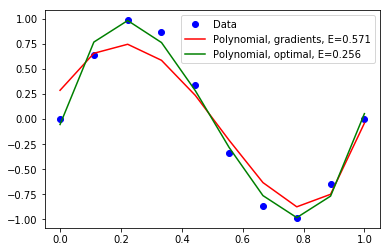

After gradient descent learning, error= 5.713e-01
Press any key to continue
Before learning, error= tensor(2.1198, dtype=torch.float64)
After gradient descent learning, error= 4.131e-01


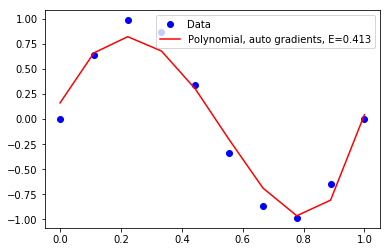

In [516]:
import math
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1)
batch_size=10
N_in=1
N_out=1
device=torch.device('cpu')
dtype=torch.float64
x = torch.linspace(0, 1, batch_size, requires_grad=False,dtype=dtype,device=device).view(batch_size,1)
t = torch.sin(2*math.pi*x).view(batch_size,1)

M=5
Phi = torch.DoubleTensor( [ [j**i for i in range(M) ] for j in x  ] )
y1=Phi@torch.inverse(Phi.t()@Phi)@Phi.t()@t

w = torch.randn(M,1,dtype=dtype,device=device)
y = Phi@w 


lr=0.05
print("Before learning, error=",(y-t).norm())

for epoch in range(5000):
    w = w - lr * Phi.t()@(Phi@w-t)   # the gradients
    y = Phi@w 

plt.plot(x.detach().numpy(), t.detach().numpy(), 'bo', label='Data')
plt.plot(x.detach().numpy(), y.detach().numpy(), 'r-', label='Polynomial, gradients, E=%.3f'%(y-t).norm())
plt.plot(x.detach().numpy(), y1.detach().numpy(), 'g-', label='Polynomial, optimal, E=%.3f'%(y1-t).norm())
plt.legend(loc=1)
plt.show()

print("After gradient descent learning, error= %.3e"%(y-t).norm())
input("Press any key to continue")

nn = Sequential([Linear(M,N_out),MSE(t)])
E = nn.forward(Phi)
nn.backward(1)

lr=0.1
y = nn.layers[0].y
print("Before learning, error=",(y-t).norm())
for epoch in range(20000):
    for l in nn.layers:
        if hasattr(l, 'params'):
            for i in range(len(l.params)):
                l.params[i] = l.params[i] - lr * l.grad[i]
    y = nn.layers[0].y
    E = nn.forward(Phi)
    nn.backward(1)
print("After gradient descent learning, error= %.3e"%(y-t).norm())
plt.ion()
plt.plot(x.detach().numpy(), t.detach().numpy(), 'bo', label='Data')
plt.plot(x.detach().numpy(), y.detach().numpy(), 'r-', label='Polynomial, auto gradients, E=%.3f'%(y-t).norm())
plt.legend(loc=1)
plt.draw()
    

### Fitting the sin function using a MLP

Before learning, error= 2.121e+00
After learning, error= 3.080e-02


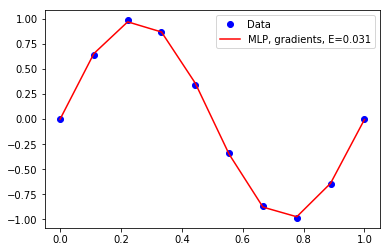

In [517]:
import math
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1)
batch_size=10
N_in=1
N_hidden=5
N_out=1
device=torch.device('cpu')
dtype=torch.float64
nn = Sequential([Linear(N_in,N_hidden),Tanh(),Linear(N_hidden,N_out),MSE(t)])
E = nn.forward(x)
y = nn.layers[2].y
nn.backward(1)
lr=0.1
print("Before learning, error= %.3e"%(y-t).norm())
for epoch in range(20000):
    for l in nn.layers:
        if hasattr(l, 'params'):
            for i in range(len(l.params)):
                l.params[i] = l.params[i] - lr * l.grad[i]
    E = nn.forward(x)
    y = nn.layers[2].y
    nn.backward(1)
print("After learning, error= %.3e"%(y-t).norm())
plt.plot(x.detach().numpy(), t.detach().numpy(), 'bo', label='Data')
plt.plot(x.detach().numpy(), y.detach().numpy(), 'r-', label='MLP, gradients, E=%.3f'%(y-t).norm())
plt.legend(loc=1)
plt.show()